Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.patches
plt.rcParams['figure.figsize'] = 16, 6
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

First add regularization to the logistic regression example. Based on example from: https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/models/image/mnist/convolutional.py

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weights))
  # Add the regularization term to the loss.
  loss += 5e-4 * regularizers
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Run logistic regression with L2 regularization

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.549574
Minibatch accuracy: 4.7%
Validation accuracy: 10.8%
Minibatch loss at step 500: 2.460678
Minibatch accuracy: 73.4%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.412287
Minibatch accuracy: 80.5%
Validation accuracy: 77.6%
Minibatch loss at step 1500: 1.492358
Minibatch accuracy: 79.7%
Validation accuracy: 79.2%
Minibatch loss at step 2000: 0.988550
Minibatch accuracy: 88.3%
Validation accuracy: 79.2%
Minibatch loss at step 2500: 1.109251
Minibatch accuracy: 81.2%
Validation accuracy: 80.6%
Minibatch loss at step 3000: 0.985119
Minibatch accuracy: 75.8%
Validation accuracy: 81.0%
Test accuracy: 88.1%


There is a slight improvement from using regularization

Now add regularization to a simple neural network

In [7]:
beta = 1e-5
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)


batch_size = 128
hidden_layer_dim = 1024

def simple_nn(x, weights_1, biases_1, weights_2, biases_2):
    hidden_layer = tf.nn.relu(tf.matmul(x, weights_1) + biases_1)
    logits = tf.matmul(hidden_layer, weights_2) + biases_2
    return logits

In [8]:
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    #####################
    ### first layer #####
    #####################
    # Variables.
    weights_1 = weight_variable([image_size * image_size, hidden_layer_dim])
    biases_1 = bias_variable([hidden_layer_dim])

    weights_2 = weight_variable([hidden_layer_dim, num_labels])
    biases_2 = bias_variable([num_labels])

    # Training computation.
    logits = simple_nn(tf_train_dataset, weights_1, biases_1, weights_2, biases_2)

    # Loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
    # Add the regularization term to the loss.
    loss += beta * regularizers

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(simple_nn(tf_valid_dataset, weights_1, biases_1, weights_2, biases_2))

    test_prediction = tf.nn.softmax(simple_nn(tf_test_dataset, weights_1, biases_1, weights_2, biases_2))
    

num_steps = 4001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.304495
Minibatch accuracy: 12.5%
Validation accuracy: 37.7%
Minibatch loss at step 500: 0.481019
Minibatch accuracy: 85.2%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.425945
Minibatch accuracy: 85.9%
Validation accuracy: 86.0%
Minibatch loss at step 1500: 0.580448
Minibatch accuracy: 85.9%
Validation accuracy: 87.6%
Minibatch loss at step 2000: 0.271807
Minibatch accuracy: 91.4%
Validation accuracy: 88.0%
Minibatch loss at step 2500: 0.506337
Minibatch accuracy: 84.4%
Validation accuracy: 88.4%
Minibatch loss at step 3000: 0.369680
Minibatch accuracy: 91.4%
Validation accuracy: 89.0%
Minibatch loss at step 3500: 0.306862
Minibatch accuracy: 90.6%
Validation accuracy: 89.1%
Minibatch loss at step 4000: 0.215989
Minibatch accuracy: 93.8%
Validation accuracy: 89.1%
Test accuracy: 94.7%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
batch_size = 128
hidden_layer_dim = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    #####################
    ### first layer #####
    #####################
    # Variables.
    weights_1 = weight_variable([image_size * image_size, hidden_layer_dim])
    biases_1 = bias_variable([hidden_layer_dim])

    weights_2 = weight_variable([hidden_layer_dim, num_labels])
    biases_2 = bias_variable([num_labels])

    # Training computation.
    logits = simple_nn(tf_train_dataset, weights_1, biases_1, weights_2, biases_2)

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
    
    # Loss function. Add the regularization term to the loss.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * regularizers
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(simple_nn(tf_valid_dataset, weights_1, biases_1, weights_2, biases_2))

    test_prediction = tf.nn.softmax(simple_nn(tf_test_dataset, weights_1, biases_1, weights_2, biases_2))
    

num_steps = 501

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.298821
Minibatch accuracy: 10.9%
Validation accuracy: 41.3%
Minibatch loss at step 500: 0.476666
Minibatch accuracy: 85.9%
Validation accuracy: 85.4%
Test accuracy: 91.7%


The same small number of batches with no regularization

In [10]:
batch_size = 128
hidden_layer_dim = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    #####################
    ### first layer #####
    #####################
    # Variables.
    #weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_dim]))
    #biases_1 = tf.Variable(tf.zeros([hidden_layer_dim]))
    
       
    #weights_2 = tf.Variable( tf.truncated_normal([hidden_layer_dim, num_labels]))
    #biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    weights_1 = weight_variable([image_size * image_size, hidden_layer_dim])
    biases_1 = bias_variable([hidden_layer_dim])

    weights_2 = weight_variable([hidden_layer_dim, num_labels])
    biases_2 = bias_variable([num_labels])

    # Training computation.
    logits = simple_nn(tf_train_dataset, weights_1, biases_1, weights_2, biases_2)

    # Loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
     # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(simple_nn(tf_valid_dataset, weights_1, biases_1, weights_2, biases_2))

    test_prediction = tf.nn.softmax(simple_nn(tf_test_dataset, weights_1, biases_1, weights_2, biases_2))
    

num_steps = 501

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.304413
Minibatch accuracy: 7.0%
Validation accuracy: 41.4%
Minibatch loss at step 500: 0.467176
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Test accuracy: 91.8%


The results are similar

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [11]:
batch_size = 128
hidden_layer_dim = 1024
num_steps = 30001
SEED = 66478

def nn_with_dropout(x, weights_1, biases_1, weights_2, biases_2, keep_prob, train=True):
    '''
    Simple nn with dropout
    '''
    hidden_layer = tf.nn.relu(tf.matmul(x, weights_1) + biases_1)
    # Adding dropout layer
    if train:
        hidden_layer = tf.nn.dropout(hidden_layer, 0.5, seed=SEED)
        
    logits = tf.matmul(hidden_layer, weights_2) + biases_2
    return logits

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    keep_prob = tf.placeholder(tf.float32)#for drop out

    #####################
    ### first layer #####
    #####################
    # Variables.
    weights_1 = weight_variable([image_size * image_size, hidden_layer_dim])
    biases_1 = bias_variable([hidden_layer_dim])

    weights_2 = weight_variable([hidden_layer_dim, num_labels])
    biases_2 = bias_variable([num_labels])

    # Training computation.
    logits = nn_with_dropout(tf_train_dataset, weights_1, biases_1, weights_2, biases_2, keep_prob)

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
    
    # Loss function. Add the regularization term to the loss.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * regularizers
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(nn_with_dropout(tf_valid_dataset, weights_1, biases_1, weights_2, biases_2, None, False))
    test_prediction = tf.nn.softmax(nn_with_dropout(tf_test_dataset, weights_1, biases_1, weights_2, biases_2, None, False))
 

Now train

Initialized
Minibatch loss at step 0: 2.307951
Minibatch accuracy: 10.2%
Validation accuracy: 41.5%
Minibatch loss at step 500: 0.574442
Minibatch accuracy: 80.5%
Validation accuracy: 84.6%
Minibatch loss at step 1000: 0.490589
Minibatch accuracy: 83.6%
Validation accuracy: 85.1%
Minibatch loss at step 1500: 0.707773
Minibatch accuracy: 81.2%
Validation accuracy: 86.8%
Minibatch loss at step 2000: 0.400853
Minibatch accuracy: 89.1%
Validation accuracy: 87.3%
Minibatch loss at step 2500: 0.710152
Minibatch accuracy: 83.6%
Validation accuracy: 88.2%
Minibatch loss at step 3000: 0.488178
Minibatch accuracy: 86.7%
Validation accuracy: 87.9%
Minibatch loss at step 3500: 0.444946
Minibatch accuracy: 89.1%
Validation accuracy: 88.3%
Minibatch loss at step 4000: 0.271859
Minibatch accuracy: 93.8%
Validation accuracy: 88.2%
Minibatch loss at step 4500: 0.369044
Minibatch accuracy: 89.8%
Validation accuracy: 88.4%
Minibatch loss at step 5000: 0.446147
Minibatch accuracy: 86.7%
Validation accurac

/usr/lib/pymodules/python2.7/matplotlib/legend.py:317: UserWarning: Unrecognized location "validate". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(self.codes.iterkeys())))


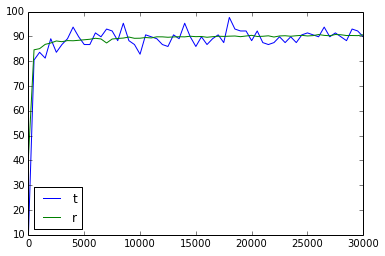

In [12]:
sample_accuracy_step = 500
with tf.Session(graph=graph) as session:
    train_loss = []
    validation_loss = []
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            train_loss.append(accuracy(predictions, batch_labels))
            validation_loss.append(accuracy(valid_prediction.eval(), valid_labels))
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % train_loss[-1])
            print("Validation accuracy: %.1f%%" % validation_loss[-1])
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    # Plot learning curve
    plt.figure()
    plt.plot(np.arange(len(train_loss))*sample_accuracy_step, train_loss, label="train")
    plt.plot(np.arange(len(train_loss))*sample_accuracy_step, validation_loss, label="validate")
    plt.legend("train", "validate")


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [13]:
hidden_layer_spec = np.array([1024, 300])
num_of_hidden_layers = hidden_layer_spec.shape[0]

def nn_with_dropout(x, weights, biases, keep_probs, train=True):
    '''
    Deep nn with dropout
    '''
    hidden_layer = tf.nn.relu(tf.matmul(x, weights[0]) + biases[0])
    # Adding dropout layer
    if train:
        hidden_layer = tf.nn.dropout(hidden_layer, 0.5, seed=SEED)
        
    logits = tf.matmul(hidden_layer, weights[1]) + biases[1]
    return logits